Tests with separate DiaObjectLast table used as index for last version of DiaSource. Storage is SSD.

In [1]:
%pylab inline
plt.style.use('bmh');

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [3]:
def do_plot(ds, name, figsize = (10, 8)):
    ds.plot(y=['select_real', 'store_real'], style=['o', 'r+'], title=name, figsize=figsize)

def do_boxplot(ds, by_col_name, columns, title='', bin=100, figsize=(8, 3)):
    for col in columns:
        ds.boxplot(col, by=by_col_name, figsize=figsize, showmeans=True, sym='x', whis='range')
        x = ds.index
        y = ds[col]
        try:
            x = x/bin
            p = polyfit(x, y, 1)
            y = x*p[0] + p[1]
            label = "fit: {:.3f} + {:.3f}*visit/1000".format(p[1], p[0])
            # x + 1 is needed because boxplot draws in strange coordinates
            plt.plot(x+1, y, "--g", label=label)
            plt.legend()
        except:
            pass

        plt.title("")
        plt.suptitle(title + ": " + col)

def do_plots(file_name, title, bin=100, filter_count=True):
    ds = pd.read_csv(file_name, header=0, index_col='visit')
    if filter_count:
        # filter out records doing COUNT(*) which takes long time
        ds = ds[ds.src_count.isnull()]
    ds = ds.fillna(0, axis=1)
    
    ds['obj_store'] = ds['obj_last_delete_real'] + ds['obj_last_insert_real'] + ds['obj_insert_real']
    
    # do "scatter" plot
    do_plot(ds, title)
    
    # box plots
    col_name = 'visit/' + str(bin)
    ds[col_name] = np.array(ds.index/bin, dtype=int64)
    do_boxplot(ds, col_name, ['select_real', 'store_real'], bin=bin, title=title)
    do_boxplot(ds, col_name, ['obj_select_real', 'obj_last_delete_real', 'obj_last_insert_real', 'obj_insert_real', 'obj_store',
                    'src_select_real', 'src_insert_real', 'fsrc_select_real', 'fsrc_insert_real'],
               bin=bin, title=title, figsize=(8, 2.75))
    return ds

Postgres with DiaObjectLast table on SSD
=================================

`DiaObject` PK is `(diaObjectId, validityStart)`, indices on `validityStart` and `htmId20`.

`DiaObjectLast` PK is `(htmId20, diaObjectId)`, index on `diaObjectId`.


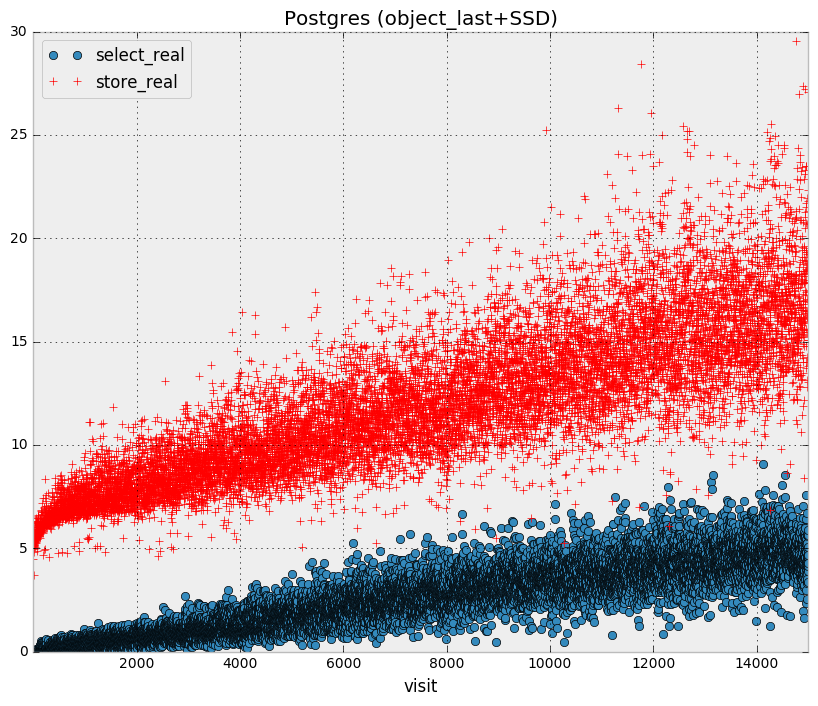

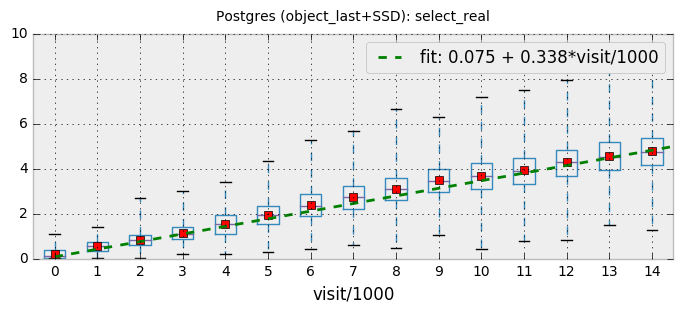

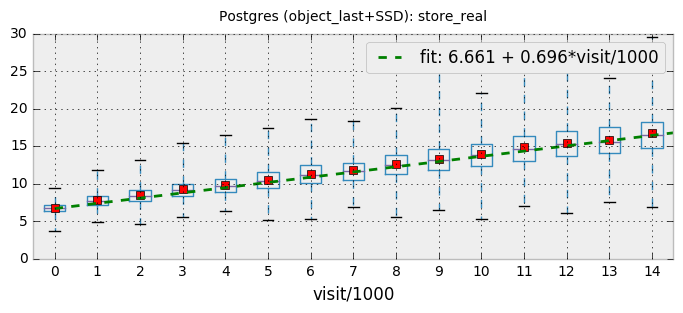

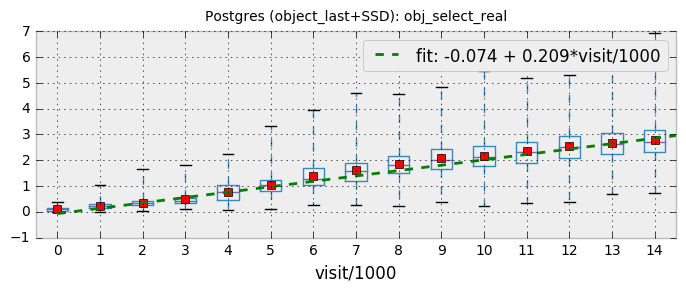

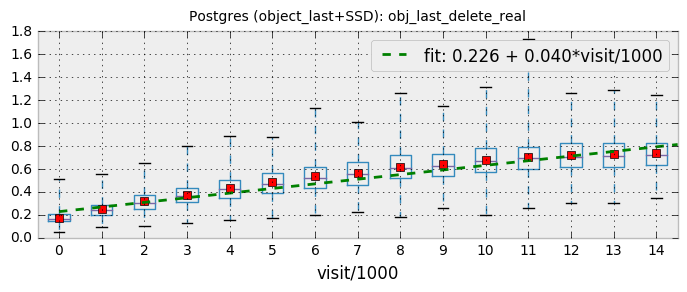

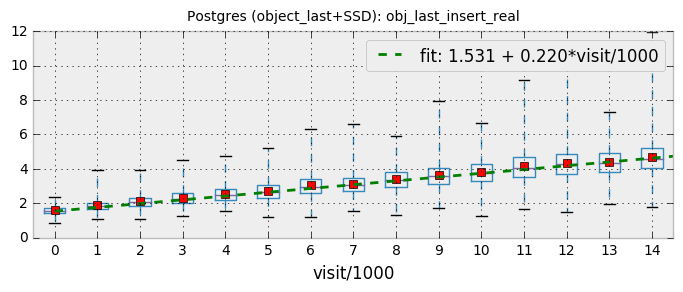

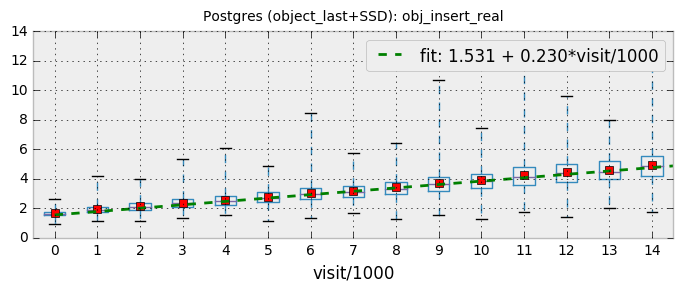

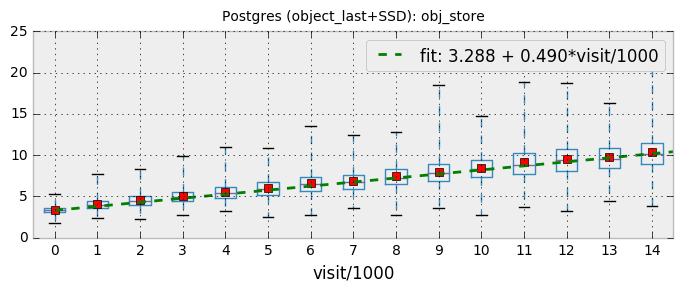

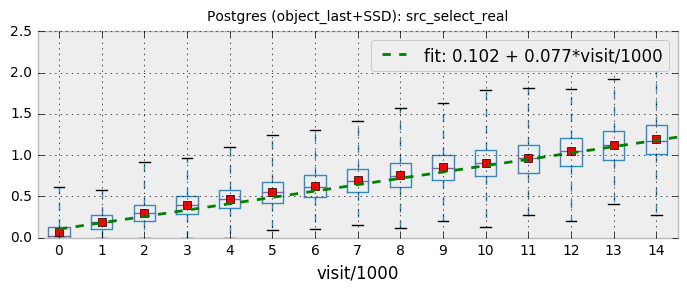

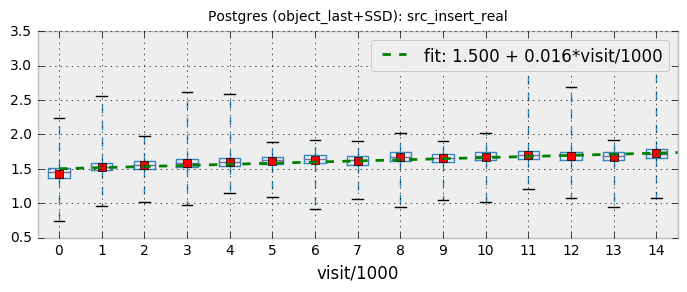

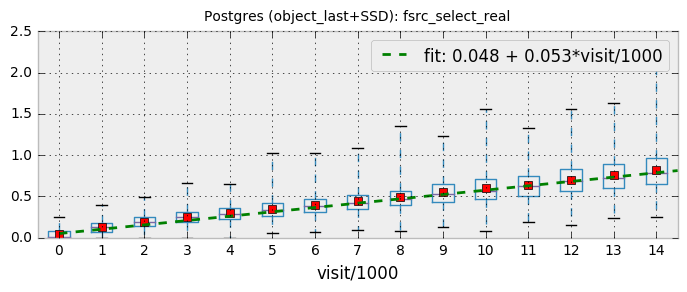

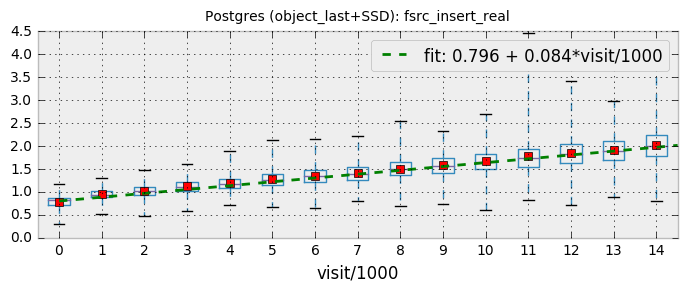

In [4]:
ds = do_plots("data/l1db-pg-ssd-last_table.csv.gz", "Postgres (object_last+SSD)", bin=1000, filter_count=True)

MySQL with DiaObjectLast table on SSD
=====================================

`DiaObject` PK is `(diaObjectId, validityStart)`, indices on `validityStart` and `htmId20`.

`DiaObjectLast` PK is `(htmId20, diaObjectId)`, index on `diaObjectId`.

DiaObjectLast updated happens in two steps (just like in Postgres) - delete existing matching records first and inserting new ones after that.

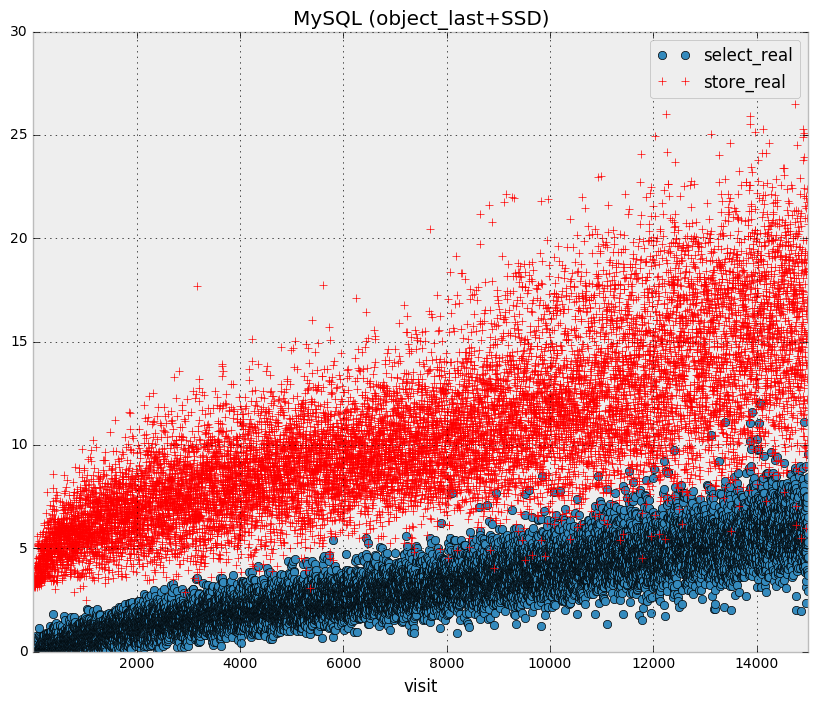

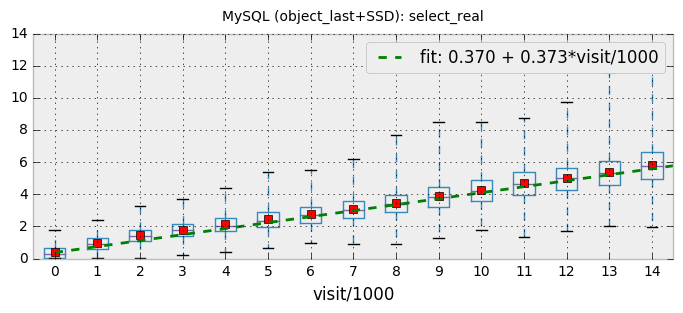

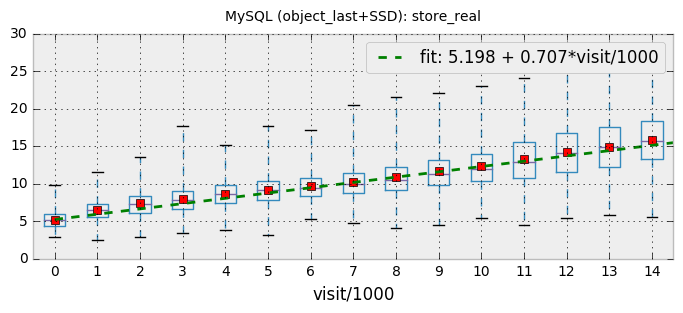

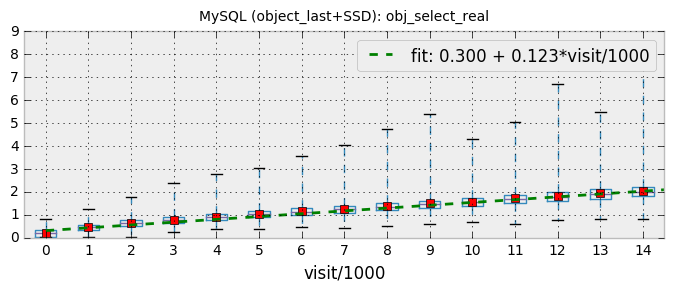

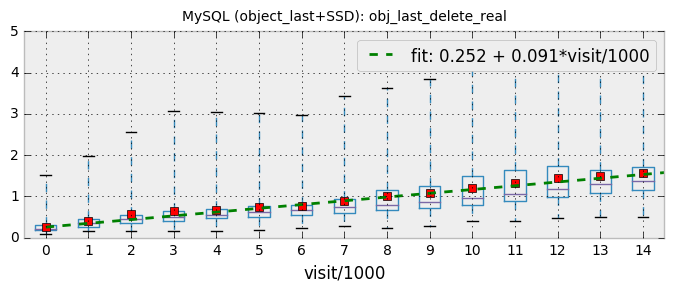

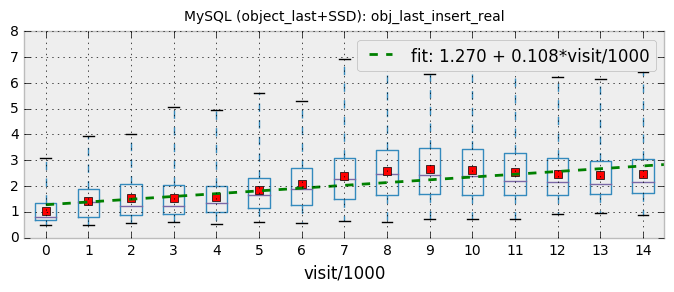

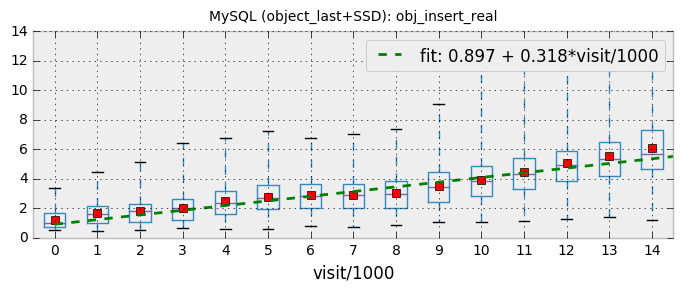

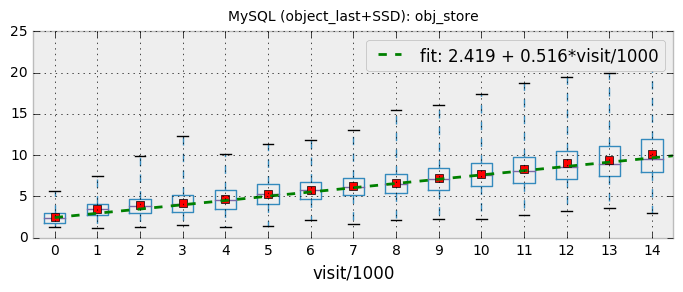

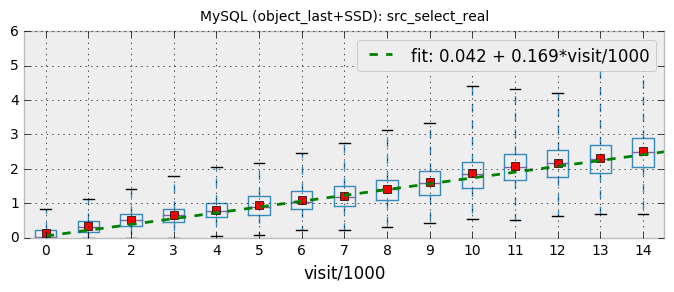

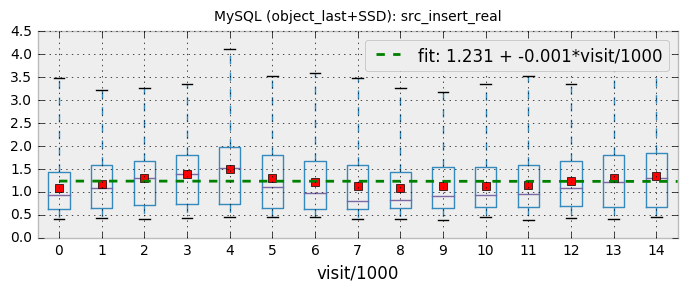

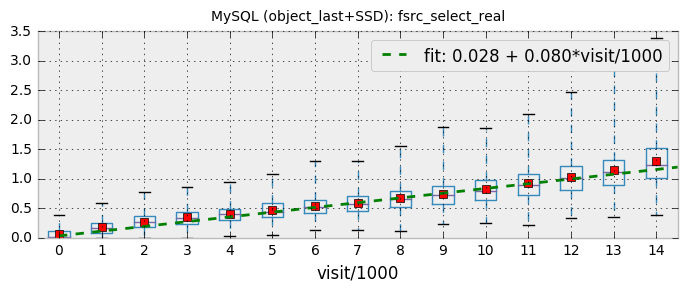

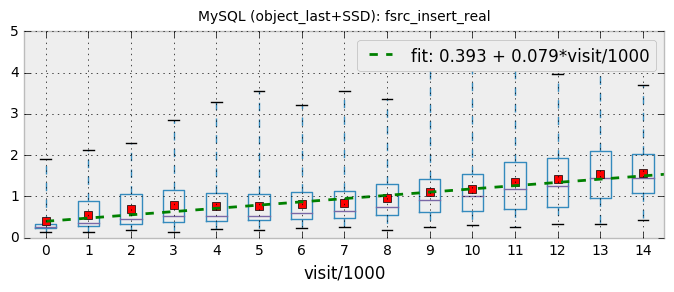

In [5]:
do_plots("data/l1db-mariadb-10-ssd-last_table.csv.gz", "MySQL (object_last+SSD)", bin=1000, filter_count=True);

Same MySQL configuration but update to DiaObjectLast table happens in a single REPLACE statement instead of DELETE + INSERT.


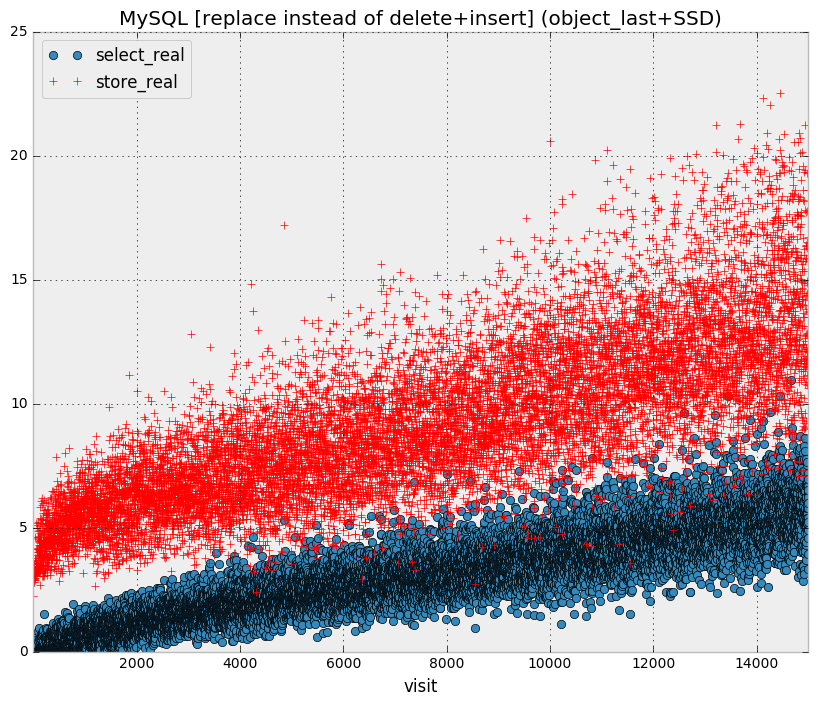

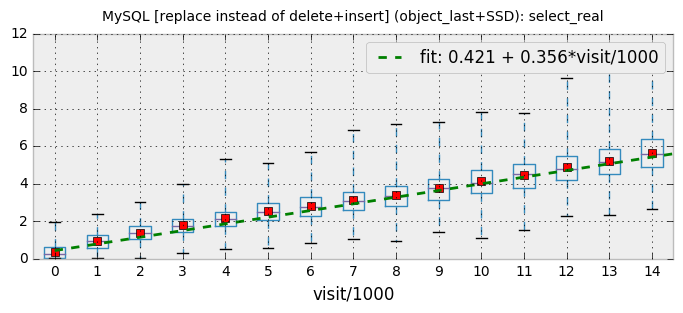

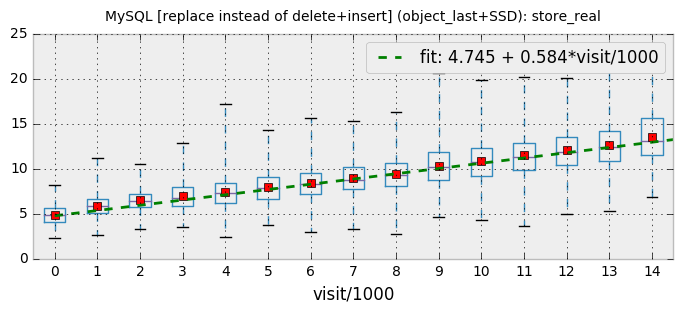

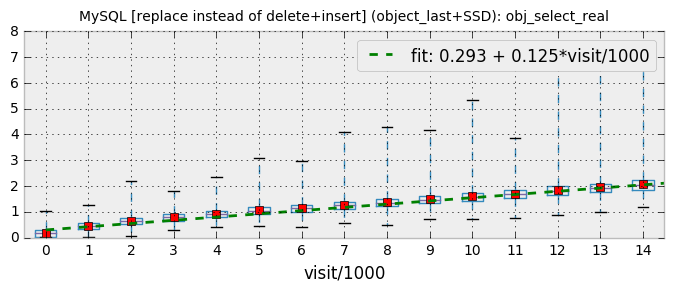

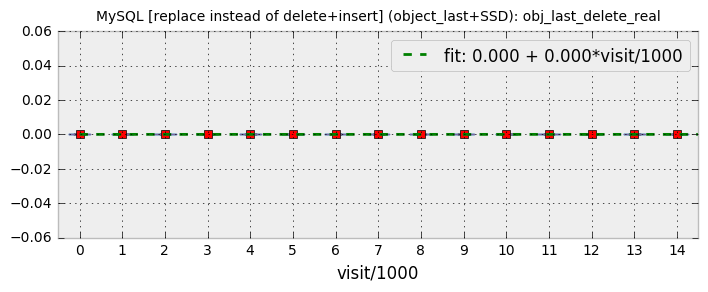

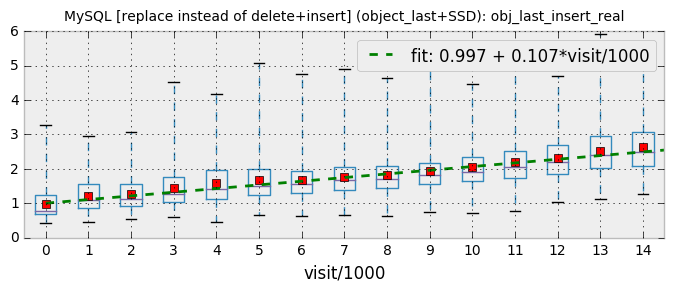

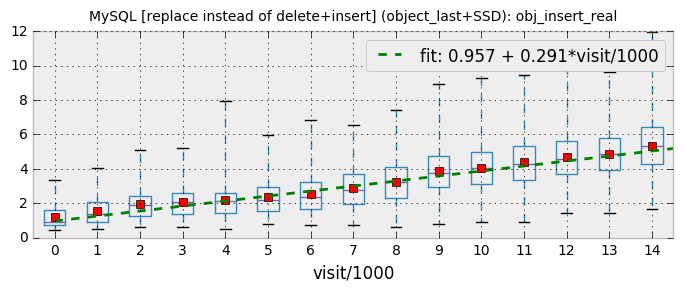

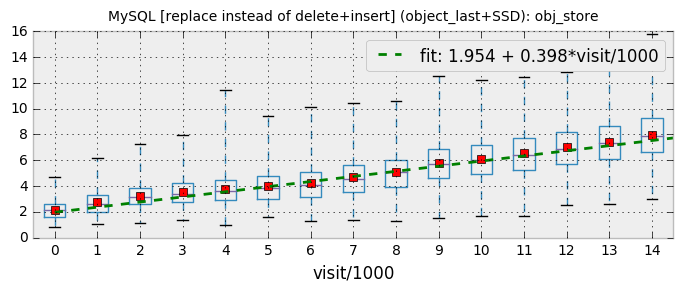

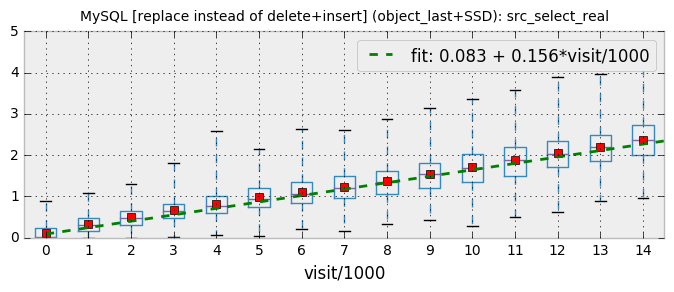

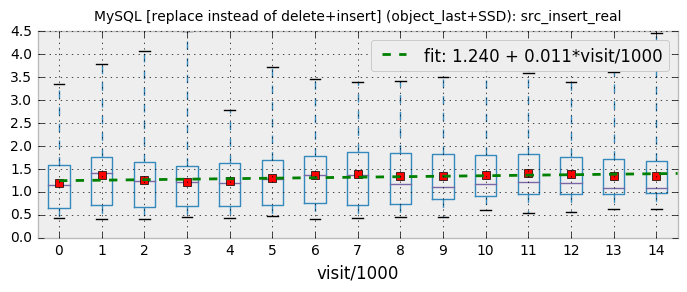

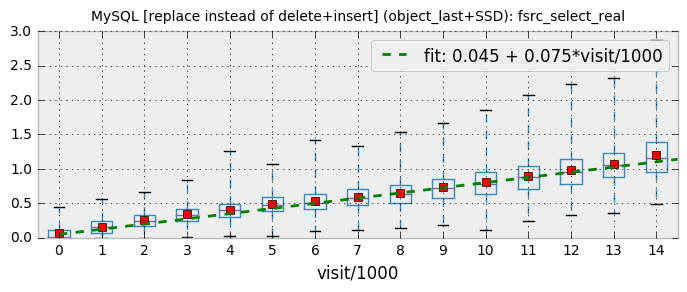

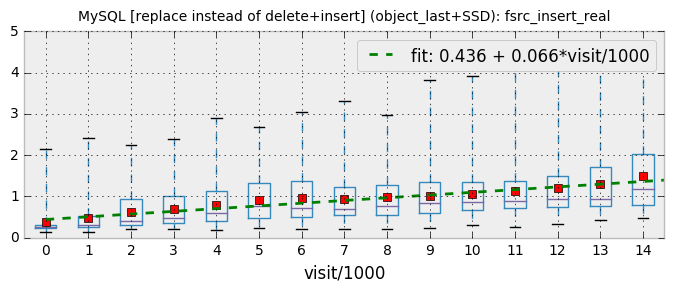

In [6]:
ds = do_plots("data/l1db-mariadb-10-ssd-last_table-replace.csv.gz", "MySQL [replace instead of delete+insert] (object_last+SSD)", bin=1000, filter_count=True);